<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/Brg1_KD_sustained_Etv2_peaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Brg1 KD ATAC-seq data at D7

by Wuming Gong



In [1]:
start_time0 <- Sys.time()

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

### Install R packages

In [4]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
required_packages <- c(
  'devtools', 'gplots', 'circlize', 'dplyr',
  'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10', 'BiocParallel',
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 'ComplexHeatmap',
  'org.Mm.eg.db', 'clusterProfiler', 'ReactomePA',
  'gsl', 'DirichletMultinomial', 'chromVAR', 'motifmatchr' # chromVAR related packages
)
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'gplots', 'circlize',
  'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10', 'BiocParallel',
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'ComplexHeatmap', 'org.Mm.eg.db',
  'clusterProfiler', 'ReactomePA', 'gsl', 'DirichletMultinomial', 'chromVAR',
  'motifmatchr'

also installing the dependencies ‘bit’, ‘pracma’, ‘R.oo’, ‘R.methodsS3’, ‘formatR’, ‘bit64’, ‘plogr’, ‘gridExtra’, ‘fastmatch’, ‘tweenr’, ‘polyclip’, ‘poweRlaw’, ‘annotate’, ‘R.utils’, ‘sass’, ‘jquerylib’, ‘bitops’, ‘GenomeInfoDbData’, ‘lambda.r’, ‘futile.options’, ‘Rhtslib’, ‘rjson’, ‘RSQLite’, ‘AnnotationFilter’, ‘ProtGenerics’, ‘BiocFileCache’, ‘cowplot’, ‘reshape2’, ‘scatterpie’, ‘shadowtext’, ‘DO.db’, ‘fgsea’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘checkmate’, ‘RcppEigen’, ‘CNEr’, ‘seqLogo’, ‘TFMPvalue’, ‘data.table’, ‘httpuv’

### Install `chromVARmotifs` package required for `chromVAR`

In [6]:
devtools::install_github("GreenleafLab/chromVARmotifs")

cachem (1.0.1 -> 1.0.3) [CRAN]


Installing 1 packages: cachem

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmp770W1w/remotes4c1a548df3/GreenleafLab-chromVARmotifs-38bed55/DESCRIPTION’
─  preparing ‘chromVARmotifs’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘chromVARmotifs_0.2.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Load R packages

In [7]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
register(MulticoreParam(2))
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(dplyr)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(rtracklayer)
library(parallel)
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(clusterProfiler)
library(ReactomePA)



Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attac

In [8]:
data("homer_pwms") 

## Read and process the ATAC-seq read counts data 
Read data for each sample and count the motifs at each interval

In [11]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228a/all_ATAC.rds')))
se

class: RangedSummarizedExperiment 
dim: 152282 30 
metadata(0):
assays(1): counts
rownames(152282): chr1 chr1 ... chrY chrY
rowData names(3): score source group
colnames(30): EB_Dox_D25_rep1 EB_Dox_D25_rep2 ...
  MEF_Brg1_KD_NoDox_D7_rep1 MEF_Brg1_KD_NoDox_D7_rep2
colData names(3): bw_file name group

In [12]:
# remove intervals that have reads in at zero or one condition
se <- se[rowSums(assays(se)$counts > 0) >= 2] 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
colData(se)$is_MEF <- grepl('^MEF_', colData(se)$group)
colData(se)$is_EB <- grepl('^EB_', colData(se)$group)
colData(se)$is_flk1pos <- grepl('Flk1pos', colData(se)$group)
colData(se)$is_dox <- grepl('_Dox_', colData(se)$group)
colData(se)$is_Brg1_KD <- grepl('_Brg1_', colData(se)$group)
time <- gsub('_Flk1pos', '', gsub('.+_(D.+)$', '\\1', colData(se)$group))
time[time == 'MEF_NoDox'] <- 'D0'
colData(se)$time <- time

In [13]:
MEF_cols <- colorpanel(4, low = 'black', high = 'green') # time
EB_col <- 'red'
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D25' = EB_col,
  'EB_Dox_D25' = EB_col,
  'EB_Dox_D25_Flk1pos' = EB_col,
  
  'MEF_Brg1_KD_D0' = MEF_cols[1],
  'MEF_Brg1_KD_Dox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_Dox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_Dox_D7' = MEF_cols[4],
  
  'MEF_Brg1_KD_NoDox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_NoDox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_NoDox_D7' = MEF_cols[4]
)
pch <- rep(21, ncol(se))
pch[colData(se)$is_Brg1_KD] <- 24
colData(se)$pch <- pch
colData(se)$bg <- group2col[as.character(colData(se)$group)]
colData(se)$col <- group2col[as.character(colData(se)$group)]
colData(se)                             

DataFrame with 30 rows and 12 columns
                                                                                                                                                        bw_file
                                                                                                                                                       <factor>
EB_Dox_D25_rep1                             https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep1_treat_pileup.bw        
EB_Dox_D25_rep2                             https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep2_treat_pileup.bw        
EB_NoDox_D25_rep1                           https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep1_treat_pileup.bw      
EB_NoDox_D25_rep2                           https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep2_treat_pileup.bw      
EB

## chromVAR analysis

In [14]:
set.seed(1)
include <- colData(se)$is_MEF & colData(se)$time == 'D7'
se_D7 <- se[, include]
se_D7 <- se_D7[rowSums(assays(se_D7)$counts > 0) >= 2]
motif_ix <- matchMotifs(homer_pwms, se_D7, genome = 'mm10')
dev_D7 <- computeDeviations(object = se_D7, annotations = motif_ix)
v_D7 <- computeVariability(dev_D7)

PCA of the motif deiviations

# of significant motifs: 229(332)


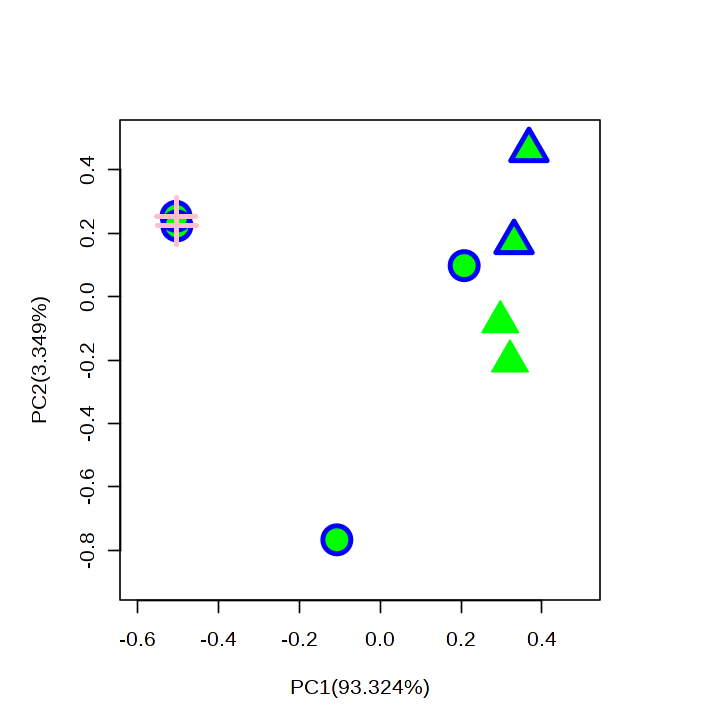

In [15]:
m <- v_D7$p_value_adj < 1e-10
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
s <- prcomp(assays(dev_D7)$z[m, ])
eigs <- s$sdev^2
z <- s$rotation

pc_x <- 1; pc_y <- 2
cex <- 3

par(mar = c(5, 5, 5, 5))
options(repr.plot.width=6, repr.plot.height=6)
plot(
  z[, pc_x], z[, pc_y], 
  pch = colData(se_D7)$pch, 
  bg = colData(se_D7)$bg, 
  col = colData(se_D7)$col, 
  cex = cex, 
  xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), 
  ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100),
  xlim = c(-0.6, 0.5),
  ylim = c(-0.9, 0.5)
)
points(
  z[colData(se_D7)$is_dox, pc_x], z[colData(se_D7)$is_dox, pc_y], 
  pch = colData(se_D7)$pch[colData(se_D7)$is_dox], 
  col = 'blue', 
  cex = cex, 
  lwd = 3
)
points(
  z[colData(se_D7)$is_flk1pos, pc_x], z[colData(se_D7)$is_flk1pos, pc_y], 
  pch = 3, 
  col = 'pink', 
  cex = cex, 
  lwd = 3
)

# of significant motifs: 46(332)


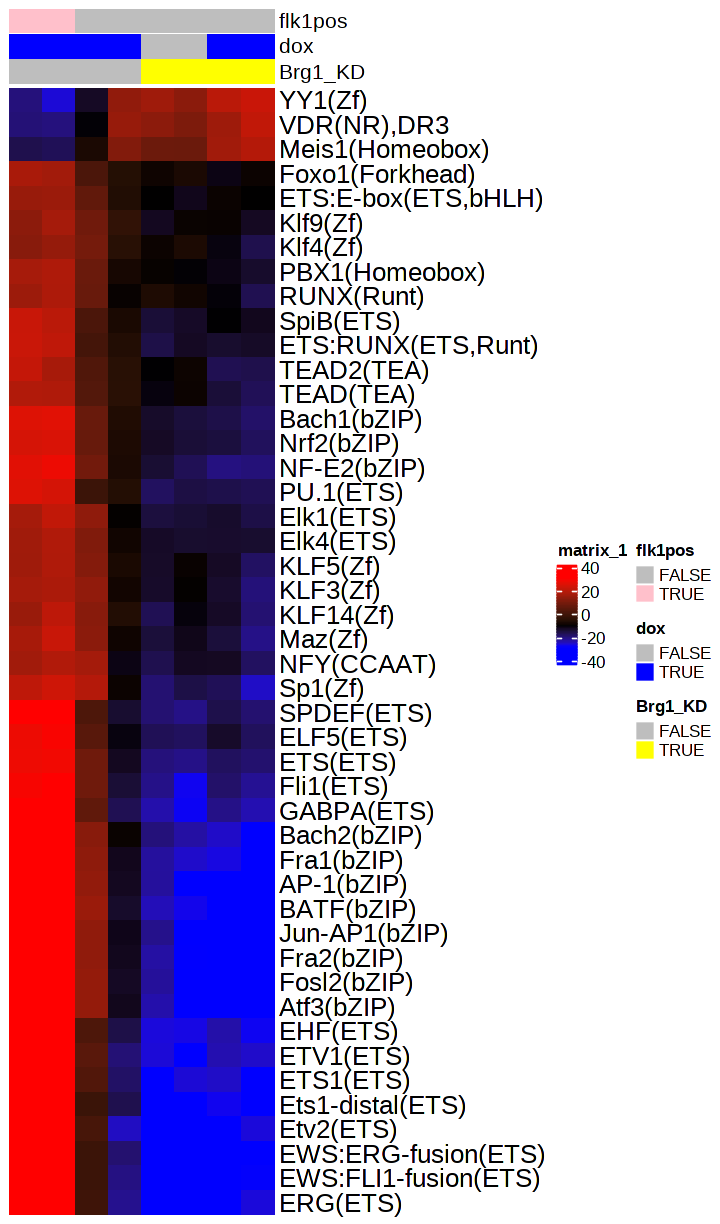

In [16]:
m <- v_D7$p_value_adj < 1e-200
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
Y <- assays(dev_D7)$z
rownames(Y) <- rowData(dev_D7)$name
Y <- Y[m, ]

column_annotation <- HeatmapAnnotation(
  flk1pos = colData(se_D7)$is_flk1pos,
  dox = colData(se_D7)$is_dox,
#  time = colData(se_D7)$time,
  Brg1_KD = colData(se_D7)$is_Brg1_KD,
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray'),
    Brg1_KD  = c('TRUE' = 'yellow', 'FALSE' = 'gray'),
    time = c('D0' = MEF_cols[1], 'D1' = MEF_cols[2],'D2' = MEF_cols[3],'D7' = MEF_cols[4])
  )
)

col_fun <- colorRamp2(quantile(Y, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

options(repr.plot.width=6, repr.plot.height = nrow(Y) * 0.2 + 1)
Heatmap(
  Y,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_gp = gpar(fontsize = 15)
)

At D7, The Etv2 motif associated chromatin accessibility decreased in Brg1 KD cells, compared with the WT reprogramming. This suggest that Brg1 may help to retain the Etv2 bindings on the chromatin, not so much related to the initialization.

## Get sustained Etv2 ChIP-seq peaks
Split the Etv2 MEF D1 peaks into three groups
* on at D1 and off at D7 (early)
* off at D1 and on at D7 (late)
* on at both D1 and D7 (sustained)

In [17]:
gr_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds' 
gr <- readRDS(gzcon(url(gr_url)))
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2'] | gr$group[, 'MEF_Dox_d7_Etv2']]
peaks

GRanges object with 127559 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       [3]     chr1   3531626-3531825      * | /panfs/roc/scratch/g..  16.22768
       [4]     chr1   3671125-3671324      * | /panfs/roc/scratch/g..   6.73792
       [5]     chr1   3671746-3671945      * | /panfs/roc/scratch/g..   9.54304
       ...      ...               ...    ... .                    ...       ...
  [127555]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [127556]     chrY 90836259-90836458      * | /panfs/roc/scratch/g..   8.27339
  [127557]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [127558]     chrY 90842563-90842762      * | /panfs/roc/scra

Select the sustained Etv2 ChIP-seq peaks that are present in both D1 and D7 post induction.

In [18]:
is_sustained <- peaks$group[, 'MEF_Dox_d1_Etv2'] & peaks$group[, 'MEF_Dox_d7_Etv2']
peaks_sustained <- peaks[is_sustained]
cat(sprintf('# of sustained Etv2 ChIP-seq peaks: %d', sum(is_sustained)))

# of sustained Etv2 ChIP-seq peaks: 12170

## Download MACS2 pileup files of ATAC-seq

In [19]:
bw_files <- c(
  'MEF_Dox_D1_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
#  'MEF_Dox_D2_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
  'MEF_Dox_D7_Etv2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
#  'MEF_NoDox_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
#  'MEF_Dox_D1_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
#  'MEF_Dox_D2_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
#  'MEF_Dox_D7_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_Brg1_KD_D0' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_D0_treat_pileup.bw',
#  'MEF_Brg1_KD_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D1_treat_pileup.bw',
#  'MEF_Brg1_KD_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D2_treat_pileup.bw',
  'MEF_Brg1_KD_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_treat_pileup.bw',
#  'MEF_Brg1_KD_NoDox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D1_treat_pileup.bw',
#  'MEF_Brg1_KD_NoDox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D2_treat_pileup.bw',
#  'MEF_Brg1_KD_NoDox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_NoDox_D7_treat_pileup.bw',
#  'MEF_Dox_D1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D1_treat_pileup.bw',
#  'MEF_Dox_D2' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D2_treat_pileup.bw',
  'MEF_Dox_D7' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_treat_pileup.bw',
  'MEF_Dox_D7_Flk1pos' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_treat_pileup.bw',
  'MEF_NoDox' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_treat_pileup.bw',
  'MNase' =	'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/MNase_treat_pileup.bw'
)

Download MACS2 pileup files (in BigWig format)
It appears that `rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'.  We need to download the bigwig files first.


In [22]:
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)
commands <- sprintf('wget -x -c -nH %s', bw_files)
res <- lapply(commands, function(command) system(command))

In [23]:
message(sprintf('all local_bw_files exist: %s', all(file.exists(local_bw_files))))

all local_bw_files exist: TRUE



## Read the ATAC-seq summits

In [24]:
# ATAC-seq summits of Brg1 KD at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Brg1KO_MEF_reprogramming_version=20200817a/MEF_Brg1_KD_Dox_D7_summits.bed'
peaks_Brg1KD_D7 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_Brg1KD_D7 <- GRanges(seqnames = peaks_Brg1KD_D7[, 1], range = IRanges(peaks_Brg1KD_D7[, 2], peaks_Brg1KD_D7[, 3]))

# ATAC-seq summits WT MEF reprogramming at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_Flk1pos_summits.bed'
peaks_D7_Flk1pos <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_D7_Flk1pos <- GRanges(seqnames = peaks_D7_Flk1pos[, 1], range = IRanges(peaks_D7_Flk1pos[, 2], peaks_D7_Flk1pos[, 3]))

# ATAC-seq summits WT MEF reprogramming at D7 post Etv2 induction
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_Dox_D7_summits.bed'
peaks_D7 <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_D7 <- GRanges(seqnames = peaks_D7[, 1], range = IRanges(peaks_D7[, 2], peaks_D7[, 3]))

# ATAC-seq summits WT MEF reprogramming at MEF (D0)
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/MEF_NoDox_summits.bed'
peaks_NoDox <- read.table(bed_file, header = FALSE, sep = '\t')
peaks_NoDox <- GRanges(seqnames = peaks_NoDox[, 1], range = IRanges(peaks_NoDox[, 2], peaks_NoDox[, 3]))

# ATAC-seq blacklist
bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/datasets=blacklists_version=20190827a/mm10.blacklist.bed.gz'
peaks_blacklist <- gzcon(url(bed_file))
peaks_blacklist <- readLines(peaks_blacklist)
peaks_blacklist <- read.table(textConnection(peaks_blacklist), header = FALSE, sep = '\t')
peaks_blacklist <- GRanges(seqnames = peaks_blacklist[, 1], range = IRanges(peaks_blacklist[, 2], peaks_blacklist[, 3]))

## Prepare normalized matrix for EnrichedHeatmap

Generate the normalizeToMatrix object for visualizing ChIP-seq-like data by `EnrichedHeatmap`. 

In [28]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
mc.cores <- 2
target_width <- width(peaks)[1]
cat(sprintf('# peaks: %d\n', length(peaks)))
cat(sprintf('target width: %d\n', target_width))

# peaks: 127559
target width: 200


In [38]:
mat <- lapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    peaks,
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
})

## Make the heatmap

Color scheme of the heatmap

In [39]:
group_cols <- c(
  'MEF_Dox_D1_Etv2' = 'red',
  'MEF_Dox_D2_Etv2' = 'red',
  'MEF_Dox_D7_Etv2' = 'red',
  'MEF_NoDox_Brg1' = 'purple',
  'MEF_Dox_D1_Brg1' = 'purple',
  'MEF_Dox_D2_Brg1' = 'purple',
  'MEF_Dox_D7_Brg1' = 'purple',
  'MEF_Brg1_KD_D0' = 'blue',
  'MEF_Brg1_KD_Dox_D1' = 'blue',
  'MEF_Brg1_KD_Dox_D2' = 'blue',
  'MEF_Brg1_KD_Dox_D7' = 'blue',
  'MEF_Brg1_KD_NoDox_D1' = 'blue',
  'MEF_Brg1_KD_NoDox_D2' = 'blue',
  'MEF_Brg1_KD_NoDox_D7' = 'blue',
  'MEF_Dox_D1' = 'blue',
  'MEF_Dox_D2' = 'blue',
  'MEF_Dox_D7' = 'blue',
  'MEF_Dox_D7_Flk1pos' = 'blue',
  'MEF_NoDox' = 'blue',
  'MNase' = 'navyblue'
)
col_fun <- lapply(names(bw_files), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

In [40]:
open_Brg1KD_D7 <- peaks %over% peaks_Brg1KD_D7
open_D7_Flk1pos <- peaks %over% peaks_D7_Flk1pos
open_D7 <- peaks %over% peaks_D7
is_black <- peaks %over% peaks_blacklist
is_Etv2_bound_D1 <- peaks$group[, 'MEF_Dox_d1_Etv2']
is_Etv2_bound_D7 <- peaks$group[, 'MEF_Dox_d7_Etv2']
is_valid <- rowMeans(mat[['MEF_NoDox']]) < 50
is_closed_in_MEF <- enriched_score(mat[['MEF_NoDox']]) < 1000
is_closed_in_Brg1_KD_D0 <- enriched_score(mat[['MEF_Brg1_KD_D0']]) < 1000
mnase_score <- enriched_score(mat[['MNase']])
is_NOR <- mnase_score > quantile(mnase_score, 0.75)
is_NFR <- mnase_score < quantile(mnase_score, 0.25)
NOR_NFR <- cut(mnase_score, quantile(mnase_score, c(0, 0.25, 0.75, 1)), include.lowest = TRUE)

In [42]:
i <- which(!open_Brg1KD_D7 & open_D7_Flk1pos & !is_black & is_Etv2_bound_D1 & is_Etv2_bound_D7 & is_valid)
sprintf('# of inclued peaks:%d', length(i)) %>% message()

# of inclued peaks:3231



`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FA

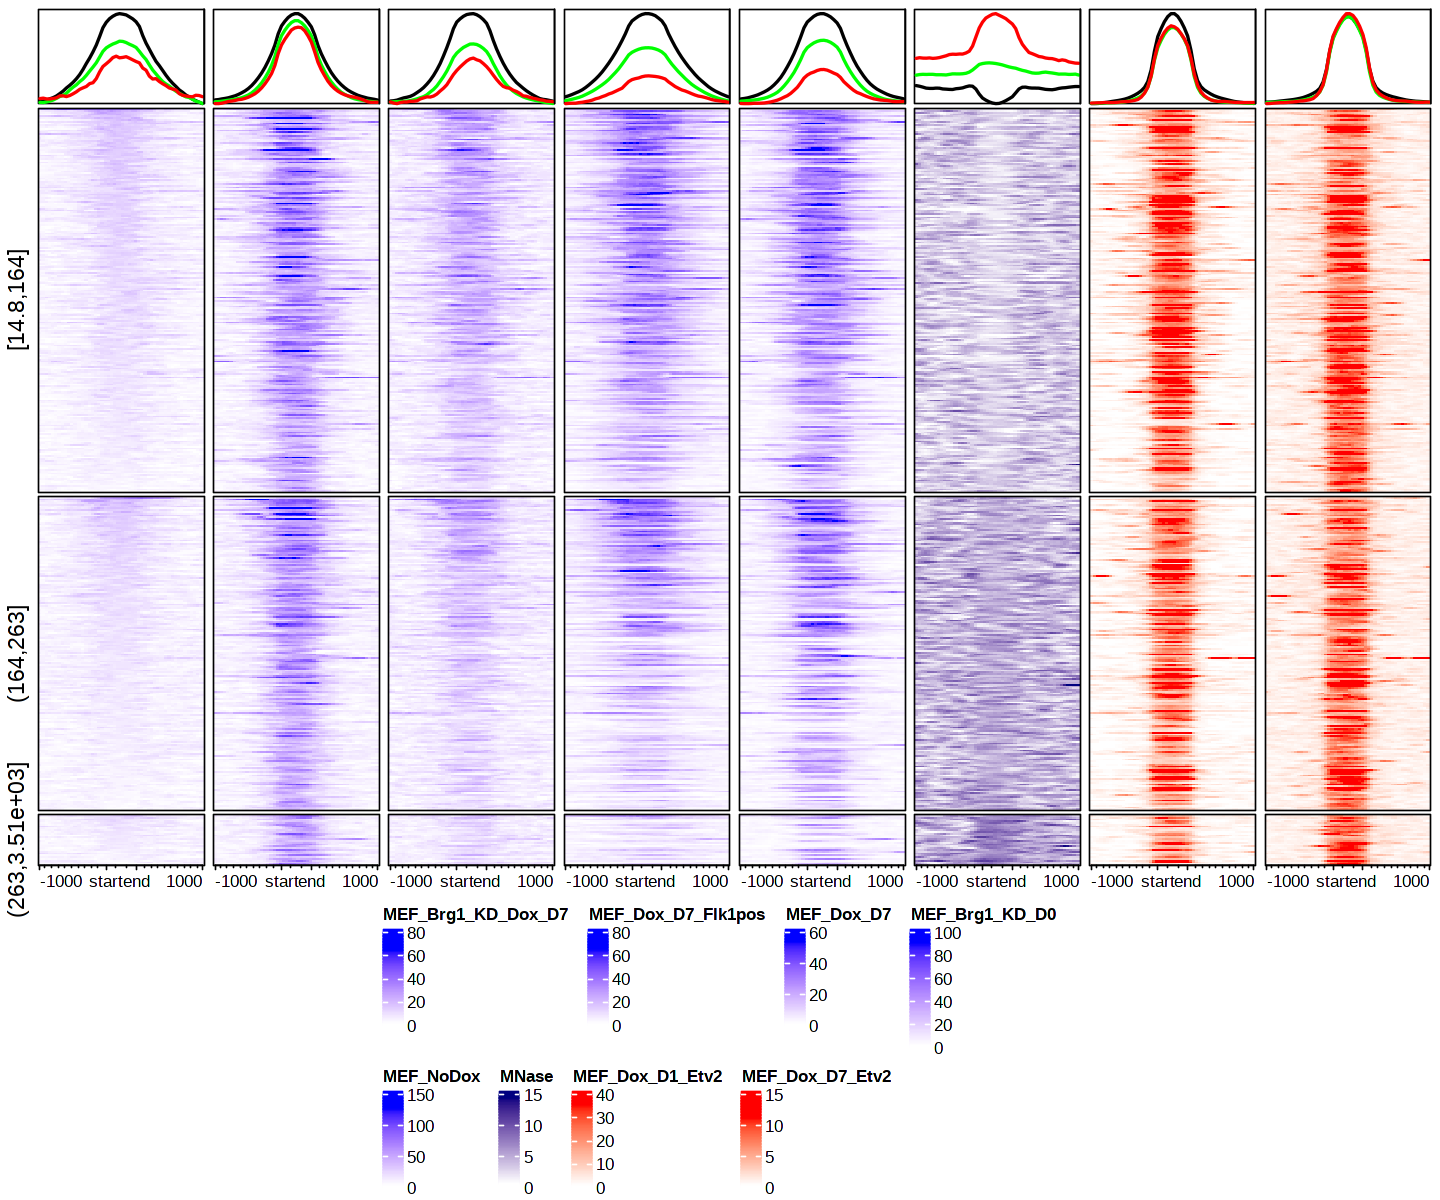

In [44]:
sp <- factor(NOR_NFR)
          
ta <- HeatmapAnnotation(
  enriched = anno_enriched(
#    gp = gpar(lty = 1, lwd = 2, col = 1:nlevels(sp)), 
    gp = gpar(lty = 1, lwd = 2, col = c('black', 'green', 'red')),
    axis_param = list(facing = 'inside',at = -1000)
  )
)
h <- EnrichedHeatmap(
  mat[['MEF_Brg1_KD_Dox_D7']][i, ], 
  col = col_fun[['MEF_Brg1_KD_Dox_D7']], 
  row_order = order(enriched_score(mat[['MEF_Brg1_KD_Dox_D7']][i, ]), decreasing = TRUE),
  split = sp[i], 

  name = 'MEF_Brg1_KD_Dox_D7', 
  top_annotation = ta, 
  pos_line = FALSE
)
ss <- c(
  'MEF_Dox_D7_Flk1pos','MEF_Dox_D7',
  'MEF_Brg1_KD_D0', 'MEF_NoDox',
  'MNase',
  'MEF_Dox_D1_Etv2', 'MEF_Dox_D7_Etv2'
)
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}
options(repr.plot.width = 12, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

The sustained Etv2 peaks can be dividied into three groups based on the initial chromatin status in MEF:

* Group 1: NOR in MEF
* Group 2: NFR in MEF
* Group 3: others

## SessionInfo

In [ ]:
sessionInfo()

In [ ]:
Sys.time() - start_time0